Data loading and cleaning

In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.mixture import GaussianMixture
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.cluster import KMeans
df = pd.read_csv('./spotify_songs.csv') 
df = df.dropna()

Clustering

In [2]:
from collections import defaultdict, Counter
from scipy.stats import entropy
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram

Entropy-Guided Decision Path Clustering algorithm.
    
This algorithm builds a hierarchical clustering tree by recursively splitting the dataset
based on the feature with the highest information gain at each step, similar to how
decision trees work, but in an unsupervised manner.

In [3]:
import numpy as np 
import pandas as pd 
from sklearn.mixture import GaussianMixture 
from sklearn.cluster import AgglomerativeClustering 
from collections import defaultdict 
import matplotlib.pyplot as plt

class EnhancedClustering: 
    def __init__(self, max_depth=5, min_samples=10, min_quality=0.1, target_clusters=None, method='tree', n_estimators=5): 
        self.max_depth = max_depth 
        self.min_samples = min_samples 
        self.min_quality = min_quality
        self.target_clusters = target_clusters
        self.method = method
        self.n_estimators = n_estimators
        self.tree = None
        self.trees = []
        self.feature_distributions = {}
        self.leaf_clusters = {}
        self.cluster_paths = {}
        self.node_samples = {}
        self.refined_clusters = None

    def fit(self, X):
        # Preprocess and optionally encode categorical features
        X_processed = self._preprocess_data(X)

        # Fit based on method
        if self.method in ['ensemble', 'combined']:
            self._fit_ensemble(X_processed)
        else:
            self._fit_single_tree(X_processed)

        # Post-processing
        if self.method == 'ancestor':
            self._apply_ancestor_grouping()
        elif self.method == 'two_phase':
            self._apply_two_phase_clustering(X_processed)
        elif self.method == 'combined':
            self._apply_combined_method(X_processed)

        return self

    def _predict_refined(self, X):
        if not hasattr(self, 'leaf_to_refined_cluster'):
            raise ValueError("No leaf_to_refined_cluster found. Make sure refinement has been applied.")
        
        Xc = self._preprocess_data(X)
        labels = []
        for _, row in Xc.iterrows():
            leaf_id = self._predict_sample(row, self.tree)  # find which leaf
            refined_cluster = self.leaf_to_refined_cluster.get(leaf_id, 0)  # fallback=0 if not in dict
            labels.append(refined_cluster)
        return np.array(labels)


    def predict(self, X):
        # For ancestor/two_phase: use leaf_to_refined_cluster if it exists
        if self.method in ['ancestor', 'two_phase', 'ensemble'] and hasattr(self, 'leaf_to_refined_cluster'):
            return self._predict_refined(X)

        # If combined method stored sample-level array, it’s okay:
        if self.method == 'combined' and self.refined_clusters is not None:
            return self.refined_clusters
        
        # If soft
        if self.method == 'soft':
            leaf_probs = self._get_soft_assignments(X)
            return self._soft_assignment_to_labels(leaf_probs)

        # Else default tree assignment
        if not self.tree:
            raise ValueError("Model has not been fitted yet.")
        return self._hard_assignment(X)


    def get_cluster_rules(self):
        """
        Returns a dictionary {cluster_id: rule_description} explaining each cluster's rules.
        """
        rules = {}
        
        # Build a reverse map: old_cluster_id -> list of node_ids
        cluster_mapping = defaultdict(list)
        for node_id, c_id in self.leaf_clusters.items():
            cluster_mapping[c_id].append(node_id)
        
        for c_id in sorted(cluster_mapping.keys()):
            node_ids = cluster_mapping[c_id]
            if not node_ids:
                rules[c_id] = "No info"
                continue

            # If multiple leaf nodes share the same cluster, we find a representative.
            # We'll pick the one with the most samples or show common features.
            paths = [self.cluster_paths.get(nid, []) for nid in node_ids if nid in self.cluster_paths]
            if not paths:
                rules[c_id] = "ROOT"
                continue
            
            # Try to find common features (approx "intersection" of path constraints)
            common = self._extract_common_features(paths)
            if common:
                # Build a rule string
                parts = []
                for feat, vals in common.items():
                    if len(vals) == 1:
                        v = list(vals)[0]
                        parts.append(f"{feat} ≈ {v}" if self._is_numerical_str(v) else f"{feat} = {v}")
                    else:
                        multi = " or ".join(str(v) for v in vals)
                        parts.append(f"{feat} in [{multi}]")
                rules[c_id] = " AND ".join(parts)
            else:
                # Just pick the path of the node with the largest sample size
                best_node = max(node_ids, key=lambda n: self.node_samples.get(n, 0))
                path = self.cluster_paths.get(best_node, [])
                if not path:
                    rules[c_id] = "ROOT"
                else:
                    rep = []
                    for f, v in path:
                        rep.append(f"{f} ≈ {v}" if self._is_numerical_str(v) else f"{f} = {v}")
                    rules[c_id] = " AND ".join(rep) + " (representative path)"

        return rules

    def plot_feature_importance(self, figsize=(8, 5)):
        """
        Simple bar chart of feature importance, computed from node quality * sample_count.
        """
        if not self.tree and not self.trees:
            raise ValueError("No fitted tree(s) found.")
        
        # Collect feature importances
        feat_importance = defaultdict(float)
        if self.trees:  # Ensemble
            for e in self.trees:
                tree = e['tree']
                local_importance = defaultdict(float)
                self._collect_tree_qualities(tree, local_importance)
                for f, val in local_importance.items():
                    # Average over ensemble
                    feat_importance[f] += val / self.n_estimators
        else:
            self._collect_tree_qualities(self.tree, feat_importance)
        
        # Convert to a sorted list
        items = sorted(feat_importance.items(), key=lambda x: -x[1])
        features = [x[0] for x in items]
        scores = [x[1] for x in items]

        # Plot using matplotlib
        plt.figure(figsize=figsize)
        y_pos = np.arange(len(features))
        plt.barh(y_pos, scores)
        plt.yticks(y_pos, features)
        plt.gca().invert_yaxis()
        plt.xlabel("Importance (Quality * N_Samples)")
        plt.title(f"Feature Importance ({self.method} method)")
        plt.tight_layout()
        plt.show()

    def plot_cluster_tree(self, figsize=(10, 6)):
        """
        Visualizes the clustering tree using networkx (if installed) and matplotlib.
        """
        if not self.tree:
            raise ValueError("No single tree to plot (method might be ensemble?).")

        try:
            import networkx as nx
        except ImportError:
            raise ImportError("Please install networkx to plot the cluster tree.")

        # Build directed graph
        G = nx.DiGraph()
        def traverse(node, parent=None):
            nid = node['node_id']
            if node['type'] == 'split':
                label = f"{node['feature']} (n={node['n_samples']})"
            else:
                label = f"Cluster {node.get('cluster',0)} (n={node['n_samples']})"
            G.add_node(nid, label=label, ntype=node['type'])

            if parent is not None:
                G.add_edge(parent, nid)

            if node['type'] == 'split':
                for ckey, child in node['children'].items():
                    G.add_edge(nid, child['node_id'], val=str(ckey))
                    traverse(child, nid)

        traverse(self.tree)

        # Positioning
        try:
            pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
        except:
            try:
                pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
            except:
                pos = nx.spring_layout(G, seed=42)

        # Split vs Leaf
        split_nodes = [n for n, d in G.nodes(data=True) if d['ntype'] == 'split']
        leaf_nodes = [n for n, d in G.nodes(data=True) if d['ntype'] == 'leaf']

        labels = {n: d['label'] for n, d in G.nodes(data=True)}

        plt.figure(figsize=figsize)
        nx.draw_networkx_nodes(G, pos, nodelist=split_nodes, node_color='lightblue')
        nx.draw_networkx_nodes(G, pos, nodelist=leaf_nodes, node_color='lightgreen')
        nx.draw_networkx_edges(G, pos)
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

        # Edge labels
        edge_labels = {(u, v): d['val'] for u, v, d in G.edges(data=True) if 'val' in d}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

        plt.title(f"Clustering Tree ({self.method} method)")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def visualize_clusters(self, X, figsize=(8, 6)):
        """
        Projects data to 2D (via PCA if >2D) and shows a scatter colored by cluster labels.
        """
        from sklearn.decomposition import PCA

        if isinstance(X, pd.DataFrame):
            X_num = X.select_dtypes(include=[np.number])
        else:
            X_num = pd.DataFrame(X)

        clusters = self.predict(X)
        if X_num.shape[1] > 2:
            pca = PCA(n_components=2, random_state=42)
            emb = pca.fit_transform(X_num)
            label_x, label_y = 'PC1', 'PC2'
        else:
            emb = X_num.values
            label_x, label_y = X_num.columns[0], (X_num.columns[1] if X_num.shape[1] == 2 else "Feature2")

        plt.figure(figsize=figsize)
        plt.scatter(emb[:, 0], emb[:, 1], c=clusters, s=40, alpha=0.8, edgecolors='k')
        plt.xlabel(label_x)
        plt.ylabel(label_y)
        plt.title(f"Cluster Visualization ({self.method} method)")
        plt.tight_layout()
        plt.show()

    # -------------------------------------------------------------
    # Internal / private methods
    # -------------------------------------------------------------
    def _preprocess_data(self, X):
        """
        Basic preprocessing: copy, handle categorical columns if needed.
        """
        Xc = X.copy()
        # For categorical columns, store a simple encoder in self.feature_distributions if not present
        for col in Xc.select_dtypes(include=['object', 'category']).columns:
            if col not in self.feature_distributions:
                uniq = Xc[col].dropna().unique()
                encoder_map = {val: i for i, val in enumerate(uniq)}
                self.feature_distributions[col] = {
                    'type': 'categorical',
                    'encoder': type('CatEncoder', (), {
                        'transform': lambda arr, em=encoder_map: [em.get(a, -1) for a in arr],
                        'classes_': list(uniq)
                    })
                }
        return Xc

    def _fit_single_tree(self, X):
        self.tree = self._build_tree(X, depth=0, node_id=1)
        # Assign cluster IDs to leaves
        self._assign_leaf_clusters(self.tree, cluster_id=0)
        # Extract final paths
        self._extract_cluster_paths(self.tree)

    def _fit_ensemble(self, X):
        self.trees = []
        n_features = len(X.columns)
        base_id = 0

        for _ in range(self.n_estimators):
            # Shuffle feature order
            feats = list(X.columns)
            np.random.shuffle(feats)

            tree = self._build_tree(X, depth=0, node_id=1, preferred_features=feats)
            # Assign clusters
            self._assign_leaf_clusters(tree, cluster_id=base_id)
            # Extract paths
            local_paths = {}
            self._extract_cluster_paths(tree, path_map=local_paths)

            # Keep leaf clusters for this tree
            # (filter out the relevant range from self.leaf_clusters)
            leaf_map = {}
            for k, v in self.leaf_clusters.items():
                if v >= base_id and v < base_id + 1000:
                    leaf_map[k] = v

            self.trees.append({
                'tree': tree,
                'paths': local_paths,
                'leaf_clusters': leaf_map
            })
            base_id += 1000

        # Combine cluster labels across trees
        self._combine_ensemble_predictions(X)

    def _build_tree(self, X, depth, node_id, parent_feature=None, preferred_features=None):
        """
        Recursively build a tree: each node is either split or leaf.
        """
        if depth >= self.max_depth or len(X) <= self.min_samples:
            return {'type': 'leaf', 'node_id': node_id, 'n_samples': len(X), 'children': {}}

        # Find best feature
        best_feat, best_dist, best_quality = self._find_best_split(X, parent_feature, preferred_features)

        # If no decent feature found, stop
        if not best_feat or best_quality < self.min_quality:
            return {'type': 'leaf', 'node_id': node_id, 'n_samples': len(X), 'children': {}}

        node = {
            'type': 'split',
            'node_id': node_id,
            'feature': best_feat,
            'distribution': best_dist,
            'quality': best_quality,
            'n_samples': len(X),
            'children': {}
        }
        self.node_samples[node_id] = len(X)

        # Split based on distribution
        feat_vals = X[best_feat]
        if isinstance(best_dist, GaussianMixture):
            # GMM
            vals = feat_vals.fillna(feat_vals.mean()).values.reshape(-1, 1)
            comps = best_dist.predict(vals)
            for c_id in range(best_dist.n_components):
                subset = X[comps == c_id]
                if len(subset) == 0:
                    continue
                child_id = node_id * 10 + c_id + 1
                node['children'][c_id] = self._build_tree(
                    subset, depth + 1, child_id, parent_feature=best_feat, preferred_features=preferred_features
                )
        elif isinstance(best_dist, dict) and best_dist['type'] == 'threshold':
            thr = best_dist['threshold']
            left = X[feat_vals <= thr]
            right = X[feat_vals > thr]
            c_id_left = node_id * 10 + 1
            c_id_right = node_id * 10 + 2
            if len(left) > 0:
                node['children'][0] = self._build_tree(left, depth+1, c_id_left, best_feat, preferred_features)
            if len(right) > 0:
                node['children'][1] = self._build_tree(right, depth+1, c_id_right, best_feat, preferred_features)
        elif isinstance(best_dist, dict) and best_dist['type'] == 'categorical':
            enc = best_dist['encoder']
            cats = enc.classes_
            for i, cat in enumerate(cats):
                subset = X[feat_vals == cat]
                if len(subset) == 0:
                    continue
                child_id = node_id * 10 + i + 1
                node['children'][i] = self._build_tree(
                    subset, depth+1, child_id, parent_feature=best_feat, preferred_features=preferred_features
                )
        else:
            # Fallback: treat as leaf
            node['type'] = 'leaf'
            node['children'] = {}

        return node

    def _find_best_split(self, X, parent_feature=None, preferred_features=None):
        best_feat = None
        best_dist = None
        best_quality = -1
        features = preferred_features if preferred_features else X.columns

        for feat in features:
            if feat == parent_feature:
                continue
            fvals = X[feat]
            if fvals.isna().sum() > len(X)*0.5 or len(fvals.unique()) <= 1:
                continue

            # If we already have a distribution for this feat, check its quality quickly
            dist_model = self.feature_distributions.get(feat, None)
            if dist_model is not None:
                q = self._calculate_distribution_quality(fvals, dist_model)
                if q > best_quality:
                    best_feat = feat
                    best_dist = dist_model
                    best_quality = q
            else:
                # Attempt to fit a GMM or threshold/categorical
                if fvals.dtype.kind in 'ifc':
                    # Fit GMM for 2-3 components
                    arr = fvals.fillna(fvals.mean()).values.reshape(-1, 1)
                    best_gmm, best_bic = None, float('inf')
                    for c in [2, 3]:
                        if len(arr) < c: 
                            continue
                        gmm = GaussianMixture(n_components=c, covariance_type='full', random_state=42)
                        gmm.fit(arr)
                        bic = gmm.bic(arr)
                        if bic < best_bic:
                            best_bic = bic
                            best_gmm = gmm
                    # Evaluate GMM
                    if best_gmm:
                        q = self._calculate_distribution_quality(arr, best_gmm)
                        if q > best_quality:
                            best_feat, best_dist, best_quality = feat, best_gmm, q
                            self.feature_distributions[feat] = best_gmm

                    # Also try threshold model
                    thr = np.median(arr)
                    thr_model = {'type': 'threshold', 'threshold': thr}
                    thr_q = self._calculate_threshold_quality(arr, thr)
                    if thr_q > best_quality:
                        best_feat, best_dist, best_quality = feat, thr_model, thr_q
                        self.feature_distributions[feat] = thr_model

                else:
                    # Categorical
                    cats = fvals.dropna().unique()
                    if len(cats) > 1:
                        enc_map = {c:i for i,c in enumerate(cats)}
                        cat_model = {
                            'type': 'categorical',
                            'encoder': type('CatEncoder', (), {
                                'transform': lambda arr, em=enc_map: [em.get(a, -1) for a in arr],
                                'classes_': list(cats)
                            })
                        }
                        cat_q = self._calculate_categorical_quality(fvals)
                        if cat_q > best_quality:
                            best_feat, best_dist, best_quality = feat, cat_model, cat_q
                            self.feature_distributions[feat] = cat_model

        return best_feat, best_dist, best_quality

    def _assign_leaf_clusters(self, node, cluster_id=0, base_id=0):
        """
        Recursively assign a cluster ID to each leaf. Also store node['cluster'] for direct predictions.
        Returns the next cluster_id to use.
        """
        if node['type'] == 'leaf':
            c = cluster_id + base_id
            self.leaf_clusters[node['node_id']] = c
            node['cluster'] = c
            return cluster_id + 1
        nxt = cluster_id
        for ch in node['children'].values():
            nxt = self._assign_leaf_clusters(ch, nxt, base_id)
        return nxt

    def _extract_cluster_paths(self, node, curr_path=None, path_map=None):
        """
        Recursively store the path for each leaf in self.cluster_paths or in path_map.
        """
        if curr_path is None:
            curr_path = []
        if path_map is None:
            path_map = self.cluster_paths  # default to the class-level dictionary

        if node['type'] == 'leaf':
            path_map[node['node_id']] = curr_path
            return
        
        feat = node['feature']
        dist = node['distribution']
        for child_key, child_node in node['children'].items():
            if isinstance(dist, GaussianMixture):
                # Use component mean or label
                if hasattr(dist, 'means_') and child_key < len(dist.means_):
                    val = f"~{dist.means_[child_key][0]:.2f}"
                else:
                    val = f"GMM_{child_key}"
            elif isinstance(dist, dict) and dist['type'] == 'threshold':
                t = dist['threshold']
                val = f"<= {t:.2f}" if child_key == 0 else f"> {t:.2f}"
            elif isinstance(dist, dict) and dist['type'] == 'categorical':
                cats = dist['encoder'].classes_
                val = str(cats[child_key]) if child_key < len(cats) else f"Cat_{child_key}"
            else:
                val = f"split_{child_key}"
            self._extract_cluster_paths(child_node, curr_path + [(feat, val)], path_map)

    def _calculate_distribution_quality(self, values, distribution):
        if isinstance(distribution, GaussianMixture):
            arr = np.array(values).reshape(-1,1)
            # Lower BIC is better => convert to [0..1] scale
            bic_val = distribution.bic(arr)
            # A rough scale: 1 - normalized BIC
            return max(0.0, 1.0 - abs(bic_val)/(10*len(arr)))
        elif isinstance(distribution, dict):
            if distribution['type'] == 'threshold':
                return self._calculate_threshold_quality(values, distribution['threshold'])
            elif distribution['type'] == 'categorical':
                return self._calculate_categorical_quality(values)
        return 0.0

    def _calculate_threshold_quality(self, vals, thr):
        vals = vals.flatten() if hasattr(vals, 'flatten') else vals
        below = np.sum(vals <= thr)
        above = len(vals) - below
        total = len(vals)
        if total == 0:
            return 0.0
        # Balanced split => good
        balance = min(below/total, above/total)*2
        return balance

    def _calculate_categorical_quality(self, vals):
        # We measure how "spread out" categories are via normalized (inverted) entropy
        vc = vals.value_counts(normalize=True)
        ent = -np.sum(vc * np.log2(vc + 1e-9))
        max_ent = np.log2(len(vc)) if len(vc) > 1 else 1.0
        return max(0.0, 1.0 - ent/max_ent)

    # --------------------------
    # Refinement / improvements
    # --------------------------
    def _apply_ancestor_grouping(self):
        """
        Groups leaf nodes by common path prefixes. A simple approach is to measure
        path similarity and cluster them by a threshold.
        """
        leaf_ids = list(self.leaf_clusters.keys())
        if not leaf_ids: return

        # Build pairwise similarity based on common path
        sims = {}
        for i in range(len(leaf_ids)):
            p1 = self.cluster_paths.get(leaf_ids[i], [])
            for j in range(i+1, len(leaf_ids)):
                p2 = self.cluster_paths.get(leaf_ids[j], [])
                # common prefix
                c_len = 0
                for a, b in zip(p1, p2):
                    if a == b:
                        c_len += 1
                    else:
                        break
                # similarity => ratio of common prefix
                denom = max(len(p1), len(p2)) or 1
                sim = c_len / denom
                sims[(leaf_ids[i], leaf_ids[j])] = sim
        
        # Form groups by a threshold on similarity
        groups = []
        used = set()
        threshold = 0.5
        pairs_sorted = sorted(sims.items(), key=lambda x: -x[1])

        for (n1, n2), sim in pairs_sorted:
            if sim < threshold:
                break
            # unify them in a group
            g1, g2 = None, None
            for idx, g in enumerate(groups):
                if n1 in g: g1 = idx
                if n2 in g: g2 = idx
            # no group => create
            if g1 is None and g2 is None:
                groups.append({n1, n2})
                used.update([n1,n2])
            elif g1 is not None and g2 is None:
                groups[g1].add(n2)
                used.add(n2)
            elif g1 is None and g2 is not None:
                groups[g2].add(n1)
                used.add(n1)
            elif g1 != g2:
                groups[g1].update(groups[g2])
                groups.pop(g2)

        for nid in leaf_ids:
            if nid not in used:
                groups.append({nid})

        # Reassign cluster IDs
        new_map = {}
        for i, grp in enumerate(groups):
            for n in grp:
                new_map[n] = i

        # Store leaf -> refined cluster in a dictionary
        self.leaf_to_refined_cluster = {leaf_id: new_map[leaf_id] for leaf_id in leaf_ids}

    def _apply_two_phase_clustering(self, X):
        """
        Phase 1: we have tree-based leaf clusters. 
        Phase 2: run a distance-based method (e.g. Agglomerative) on leaf centroids or path differences.
        """
        if not self.tree:
            return
        # Distances among leaves
        dist_mat, leaf_ids = self._build_leaf_distance_matrix()
        if dist_mat is None:
            return

        n_leaf = len(leaf_ids)
        n_clust = self.target_clusters or max(2, int(np.sqrt(n_leaf)))

        agg = AgglomerativeClustering(n_clusters=min(n_clust, n_leaf), affinity='precomputed', linkage='average')
        labels = agg.fit_predict(dist_mat)
        leaf_to_label = {leaf_ids[i]: labels[i] for i in range(n_leaf)}

        # Store the mapping of each leaf -> cluster
        self.leaf_to_refined_cluster = leaf_to_label


    def _apply_combined_method(self, X):
        """
        Combines tree-based splits + soft assignment => similarity => cluster with Agglomerative.
        """
        soft_probs = self._get_soft_assignments(X)
        n = len(soft_probs)
        if n <= 1:
            return

        # Build similarity matrix from soft probs (cosine similarity)
        sim_mat = np.eye(n)
        for i in range(n):
            for j in range(i+1, n):
                dot_ij = np.sum(soft_probs[i]*soft_probs[j])
                norm_i = np.sqrt(np.sum(soft_probs[i]**2))
                norm_j = np.sqrt(np.sum(soft_probs[j]**2))
                c = dot_ij / (norm_i*norm_j + 1e-10)
                sim_mat[i,j] = c
                sim_mat[j,i] = c
        
        dist_mat = 1.0 - sim_mat
        k = self.target_clusters or int(np.sqrt(n))
        agg = AgglomerativeClustering(n_clusters=min(k,n), affinity='precomputed', linkage='average')
        self.refined_clusters = agg.fit_predict(dist_mat)

    def _combine_ensemble_predictions(self, X):
        """
        Creates a single labeling from multiple trees by majority-vote style grouping.
        """
        # For each tree, do a hard assignment
        all_preds = []
        for tinfo in self.trees:
            self.tree = tinfo['tree']
            self.leaf_clusters = tinfo['leaf_clusters']
            all_preds.append(self._hard_assignment(X))

        # Restore to the first tree for any subsequent calls
        self.tree = self.trees[0]['tree']
        self.leaf_clusters = self.trees[0]['leaf_clusters']

        # Combine predictions: each sample gets a tuple => map tuple -> new cluster
        all_preds = np.array(all_preds)  # shape = (n_estimators, n_samples)
        combined = []
        mapping = {}
        cid = 0

        for col in all_preds.T:
            # col is shape (n_estimators,) for a single sample
            tp = tuple(col)
            if tp not in mapping:
                mapping[tp] = cid
                cid += 1
            combined.append(mapping[tp])

        self.refined_clusters = np.array(combined)

    # --------------------------
    # Helpers
    # --------------------------
    def _calculate_leaf_probabilities(self, sample, node, parent_prob=1.0):
        """
        Recursively compute the probability of the sample belonging to each leaf.
        Returns a dict {leaf_node_id: probability}.
        """
        leaf_probs = {}
        # If leaf
        if node['type'] == 'leaf':
            leaf_probs[node['node_id']] = parent_prob
            return leaf_probs

        # Determine which children (and with what probability) we follow
        feat = node['feature']
        dist = node['distribution']
        val = sample.get(feat, np.nan)

        # If no distribution or missing val, distribute evenly
        if dist is None or pd.isnull(val):
            n_child = len(node['children'])
            if n_child == 0:
                leaf_probs[node['node_id']] = parent_prob
            else:
                frac = parent_prob / n_child
                for c in node['children'].values():
                    sub_probs = self._calculate_leaf_probabilities(sample, c, frac)
                    for lid, p in sub_probs.items():
                        leaf_probs[lid] = leaf_probs.get(lid, 0) + p
            return leaf_probs

        # If GMM
        if isinstance(dist, GaussianMixture):
            arr = np.array([[val]]) if not pd.isnull(val) else np.array([[0]])
            # predict_proba => array of shape (1, n_components)
            comp_probs = dist.predict_proba(arr)[0] if dist.means_.shape[0] > 1 else [1.0]
            for c_id, child in node['children'].items():
                if c_id < len(comp_probs):
                    frac = parent_prob * comp_probs[c_id]
                    if frac > 1e-6:
                        sub_probs = self._calculate_leaf_probabilities(sample, child, frac)
                        for lid, p in sub_probs.items():
                            leaf_probs[lid] = leaf_probs.get(lid, 0) + p
            return leaf_probs

        # If threshold
        if dist['type'] == 'threshold':
            thr = dist['threshold']
            below_prob = 0.5
            above_prob = 0.5
            # Heuristic: if val <= thr => mostly go left
            if val <= thr:
                below_prob = 0.9
                above_prob = 0.1
            else:
                below_prob = 0.1
                above_prob = 0.9

            child_left = node['children'].get(0, None)
            child_right = node['children'].get(1, None)
            if child_left:
                sub_probs = self._calculate_leaf_probabilities(sample, child_left, parent_prob*below_prob)
                for lid, p in sub_probs.items():
                    leaf_probs[lid] = leaf_probs.get(lid, 0) + p
            if child_right:
                sub_probs = self._calculate_leaf_probabilities(sample, child_right, parent_prob*above_prob)
                for lid, p in sub_probs.items():
                    leaf_probs[lid] = leaf_probs.get(lid, 0) + p
            return leaf_probs

        # If categorical
        if dist['type'] == 'categorical':
            enc = dist['encoder']
            cats = enc.classes_
            try:
                idx = enc.transform([val])[0]
            except:
                # evenly distribute if unknown
                idx = -1
            n_cat = len(cats)
            cat_probs = np.ones(n_cat)*(1/n_cat)  # default uniform
            if 0 <= idx < n_cat:
                # give 90% to the matched cat, 10% to the rest
                cat_probs[:] = 0.1/(n_cat-1) if n_cat>1 else 1.0
                cat_probs[idx] = 0.9

            for c_id, child in node['children'].items():
                if c_id < len(cat_probs):
                    frac = parent_prob*cat_probs[c_id]
                    if frac>1e-6:
                        sub_probs = self._calculate_leaf_probabilities(sample, child, frac)
                        for lid, p in sub_probs.items():
                            leaf_probs[lid] = leaf_probs.get(lid, 0) + p
            return leaf_probs

        # Fallback
        n_child = len(node['children'])
        if n_child == 0:
            leaf_probs[node['node_id']] = parent_prob
        else:
            frac = parent_prob / n_child
            for c in node['children'].values():
                sub_probs = self._calculate_leaf_probabilities(sample, c, frac)
                for lid, p in sub_probs.items():
                    leaf_probs[lid] = leaf_probs.get(lid, 0) + p
        return leaf_probs

    def _get_soft_assignments(self, X):
        """
        Returns an array of shape (n_samples, n_leaves) with probabilities
        of each sample belonging to each leaf.
        """
        if not self.tree:
            raise ValueError("Model must be fitted before calling _get_soft_assignments.")
        Xc = self._preprocess_data(X)
        leaves = sorted(self.leaf_clusters.keys())
        out = np.zeros((len(Xc), len(leaves)))
        for i, (_, row) in enumerate(Xc.iterrows()):
            probs = self._calculate_leaf_probabilities(row, self.tree, 1.0)
            for j, lid in enumerate(leaves):
                out[i,j] = probs.get(lid, 0.0)
        return out

    def _soft_assignment_to_labels(self, leaf_probs):
        """
        For each row, picks the leaf with the highest probability,
        then maps leaf -> cluster ID from self.leaf_clusters.
        """
        if leaf_probs.shape[0] == 0:
            return np.array([])
        leaves = sorted(self.leaf_clusters.keys())
        leaf_map = {lid: self.leaf_clusters[lid] for lid in leaves}
        out_labels = []
        for row_probs in leaf_probs:
            if row_probs.sum() <= 1e-12:
                out_labels.append(0)
                continue
            idx = np.argmax(row_probs)
            out_labels.append(leaf_map[leaves[idx]])
        return np.array(out_labels)

    def _hard_assignment(self, X):
        """
        Descend the tree for each sample in X and pick the leaf's cluster.
        """
        Xc = self._preprocess_data(X)
        labels = []
        for _, row in Xc.iterrows():
            labels.append(self._predict_sample(row, self.tree))
        return np.array(labels)

    def _predict_sample(self, sample, node):
        """
        Recursively find the leaf node for a single sample, then return its cluster.
        """
        if node['type'] == 'leaf':
            return node.get('cluster', 0)
        feat = node['feature']
        dist = node['distribution']
        val = sample.get(feat, np.nan)

        # If distribution is missing or val is NaN => pick first child
        if dist is None or pd.isnull(val):
            if node['children']:
                return self._predict_sample(sample, next(iter(node['children'].values())))
            return node.get('cluster', 0)

        # GMM
        if isinstance(dist, GaussianMixture):
            arr = np.array([[val]]) if not pd.isnull(val) else np.array([[0]])
            comp = dist.predict(arr)[0]
            child = node['children'].get(comp, None)
            if child is not None:
                return self._predict_sample(sample, child)
            # fallback
            return node.get('cluster',0)

        # Threshold
        if dist['type'] == 'threshold':
            thr = dist['threshold']
            side = 1 if val>thr else 0
            child = node['children'].get(side, None)
            if child is not None:
                return self._predict_sample(sample, child)
            return node.get('cluster',0)

        # Categorical
        if dist['type'] == 'categorical':
            try:
                idx = dist['encoder'].transform([val])[0]
            except:
                idx = -1
            child = node['children'].get(idx, None)
            if child is not None:
                return self._predict_sample(sample, child)
            return node.get('cluster',0)

        # Fallback
        if node['children']:
            return self._predict_sample(sample, next(iter(node['children'].values())))
        return node.get('cluster',0)

    def _build_leaf_distance_matrix(self):
        """
        Builds a leaf-to-leaf distance matrix using path overlap.
        Returns (dist_matrix, sorted_leaf_ids).
        """
        leaf_ids = sorted(self.leaf_clusters.keys())
        n = len(leaf_ids)
        if n < 2:
            return None, leaf_ids
        dist = np.zeros((n,n))
        for i in range(n):
            path1 = self.cluster_paths.get(leaf_ids[i], [])
            for j in range(i+1, n):
                path2 = self.cluster_paths.get(leaf_ids[j], [])
                # find common prefix
                cl = 0
                for (fa, va), (fb, vb) in zip(path1, path2):
                    if fa == fb and va == vb:
                        cl += 1
                    else:
                        break
                denom = max(len(path1), len(path2)) or 1
                d = 1 - (cl/denom)
                dist[i,j] = d
                dist[j,i] = d
        return dist, leaf_ids

    def _extract_common_features(self, paths):
        """
        For a list of paths (each path = [(feat,val), (feat,val), ...]),
        find features that appear in at least half the paths, collecting all their encountered values.
        """
        feature_counts = defaultdict(int)
        feature_values = defaultdict(set)
        total = len(paths)

        for path in paths:
            used_feats = set()
            for (f, v) in path:
                if f not in used_feats:
                    feature_counts[f] += 1
                    used_feats.add(f)
                feature_values[f].add(v)

        common = {}
        for f, ct in feature_counts.items():
            if ct >= total/2:
                common[f] = feature_values[f]
        return common

    def _collect_tree_qualities(self, node, store):
        if node['type'] == 'split':
            f = node['feature']
            store[f] += node['quality'] * node['n_samples']
            for ch in node['children'].values():
                self._collect_tree_qualities(ch, store)
        # leaf => do nothing

    @staticmethod
    def _is_numerical_str(x):
        if isinstance(x, (int, float, np.number)):
            return True
        if isinstance(x, str):
            try:
                float(x)
                return True
            except:
                return False
        return False

In [4]:
def evaluate_clustering(X_numeric, labels):
    """
    Compute three metrics (Silhouette, Calinski-Harabasz, Davies-Bouldin).
    Returns a dict: { 'sil': float, 'calinski': float, 'davies': float }.
    If there's only 1 unique cluster, we set them to 0 to avoid errors.
    """
    n_clusters = len(set(labels))
    if n_clusters <= 1:
        return {'sil': 0.0, 'calinski': 0.0, 'davies': 0.0}
    # Compute each metric
    sil = silhouette_score(X_numeric, labels)
    calinski = calinski_harabasz_score(X_numeric, labels)
    davies = davies_bouldin_score(X_numeric, labels)
    return {'sil': sil, 'calinski': calinski, 'davies': davies}

In [5]:
def plot_clusters_2d(X_numeric, labels, title="Cluster Visualization"):
    """
    Simple 2D scatter plot of X_numeric with color-coded 'labels'.
    If X_numeric has >2 dims, we'll do a PCA(2).
    """
    from sklearn.decomposition import PCA

    if X_numeric.shape[1] > 2:
        pca = PCA(n_components=2, random_state=42)
        emb = pca.fit_transform(X_numeric)
        xlab, ylab = "PC1", "PC2"
    else:
        emb = X_numeric.values
        cols = list(X_numeric.columns)
        xlab = cols[0] if len(cols)>0 else "Feature1"
        ylab = cols[1] if len(cols)>1 else "Feature2"

    plt.scatter(emb[:, 0], emb[:, 1], c=labels, s=40, alpha=0.8, edgecolors='k')
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [6]:
df = pd.read_csv('./spotify_songs.csv') 
df = df.dropna()

In [7]:
from sklearn.model_selection import train_test_split
X = df[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']].values
y = df['playlist_genre'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df_train = pd.DataFrame(X_train, columns=[
    'danceability','energy','loudness','speechiness',
    'acousticness','instrumentalness','valence','tempo'
])


In [8]:
def evaluate_internal_metrics(X_data, labels):
    """
    Returns silhouette, calinski, davies as a dict.
    If only 1 unique cluster, sets them to 0.
    """
    n_clust = len(set(labels))
    if n_clust <= 1:
        return {'sil': 0.0, 'calinski': 0.0, 'davies': 0.0}
    sil = silhouette_score(X_data, labels)
    cal = calinski_harabasz_score(X_data, labels)
    dav = davies_bouldin_score(X_data, labels)
    return {'sil': sil, 'calinski': cal, 'davies': dav}

In [9]:
def cluster_majority_vote_accuracy(labels, true_labels):
    """
    Assigns each cluster the majority (most common) class from 'true_labels'
    and computes the overall accuracy.
    """
    from collections import Counter
    # Map: cluster_id -> list of y-values
    cluster_to_targets = {}
    for c, t in zip(labels, true_labels):
        cluster_to_targets.setdefault(c, []).append(t)
    
    # For each cluster, find the majority label
    cluster_major_label = {}
    for c, targets in cluster_to_targets.items():
        common = Counter(targets).most_common(1)[0][0]  # label with max count
        cluster_major_label[c] = common
    
    # Now measure accuracy
    correct = 0
    total = len(labels)
    for c, actual_label in zip(labels, true_labels):
        pred_label = cluster_major_label[c]
        if pred_label == actual_label:
            correct += 1
    return correct / total if total>0 else 0


Best Ensemble config={'max_depth': 3, 'min_quality': 0.2, 'target_clusters': 2} => silhouette=-0.100, calinski=4157.88, davies=6.49, acc=0.312

Best KMeans n_clusters=4 => silhouette=0.558, calinski=75044.10, davies=0.54, acc=0.288

===== Final Comparison =====
Ensemble: config={'max_depth': 3, 'min_quality': 0.2, 'target_clusters': 2}, #clusters=8, sil=-0.100, cal=4157.88, dav=6.49, acc=0.312
KMeans: config={'n_clusters': 4}, #clusters=4, sil=0.558, cal=75044.10, dav=0.54, acc=0.288


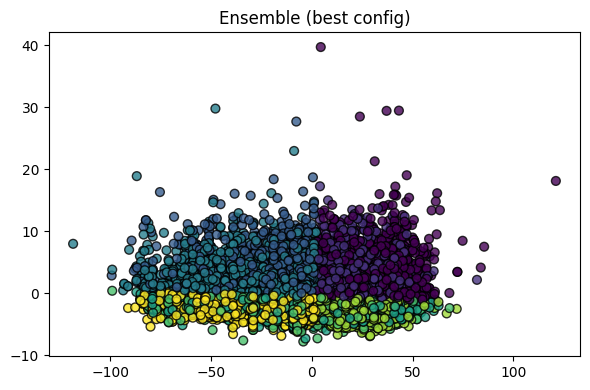

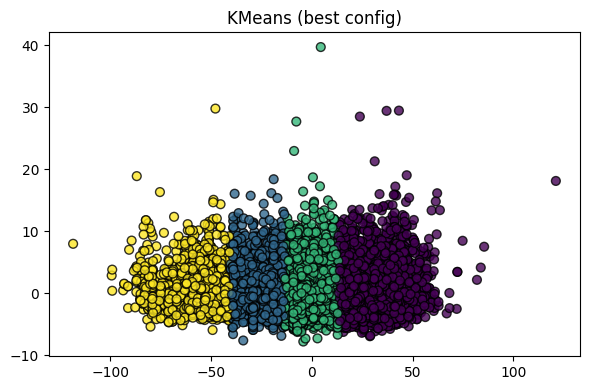


Single sample assigned to cluster [7] by ensemble method.


In [ ]:
enhanced_param_grid = [
    # Vary max_depth, min_quality, target_clusters, etc.
    {
        'max_depth': d,
        'min_quality': q,
        'target_clusters': k
    }
    for d in [3,5,7,9,11,13]         # or [3,5,7,9] if you want
    for q in [0.1,0.2,0.3,0.4,0.5,0.6]
    for k in [2,4,6,8,10,12,14,16,18,20]
]

# For this demo, we just do a single param search for 'ensemble'
# You could do other methods if you like
ec_method = 'ensemble'
n_estimators = 5

# KMeans param candidates
kmeans_clusters_grid = [2,4,6,8,10,12,14,16,18,20]

# --------------------------------------------------------------------------
# 4) Grid Search for EnhancedClustering (ensemble)
# --------------------------------------------------------------------------
best_ens_score = -999
best_ens_cfg = None
best_ens_labels = None
best_ens_metrics = None
best_ens_acc = None
best_ens_model = None

for cfg in enhanced_param_grid:
    model = EnhancedClustering(
        method=ec_method,
        max_depth=cfg['max_depth'],
        min_quality=cfg['min_quality'],
        target_clusters=cfg['target_clusters'],
        n_estimators=n_estimators
    )
    model.fit(df_train)  # pass DataFrame if needed
    labels = model.predict(df_train)

    # Compute internal metrics
    mets = evaluate_internal_metrics(X_train, labels)
    sil = mets['sil']

    # Compute external cluster "accuracy" (majority vote)
    acc = cluster_majority_vote_accuracy(labels, y_train)

    # Decide if we pick "best" by silhouette, or combine silhouette & acc, etc.
    # For demonstration, let's pick best by silhouette alone:
    if sil > best_ens_score:
        best_ens_score = sil
        best_ens_cfg = cfg
        best_ens_labels = labels
        best_ens_metrics = mets
        best_ens_acc = acc
        best_ens_model = model

print(f"\nBest Ensemble config={best_ens_cfg} => silhouette={best_ens_metrics['sil']:.3f}, "
      f"calinski={best_ens_metrics['calinski']:.2f}, davies={best_ens_metrics['davies']:.2f}, "
      f"acc={best_ens_acc:.3f}")

# --------------------------------------------------------------------------
# 5) Grid Search for KMeans
# --------------------------------------------------------------------------
best_km_score = -999
best_km_nclust = None
best_km_labels = None
best_km_metrics = None
best_km_acc = None
best_km_model = None

for k in kmeans_clusters_grid:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_train)
    labels = km.labels_

    # Internal metrics
    mets = evaluate_internal_metrics(X_train, labels)
    sil = mets['sil']

    # External "accuracy"
    acc = cluster_majority_vote_accuracy(labels, y_train)

    if sil > best_km_score:
        best_km_score = sil
        best_km_nclust = k
        best_km_labels = labels
        best_km_metrics = mets
        best_km_acc = acc
        best_km_model = km

print(f"\nBest KMeans n_clusters={best_km_nclust} => silhouette={best_km_metrics['sil']:.3f}, "
      f"calinski={best_km_metrics['calinski']:.2f}, davies={best_km_metrics['davies']:.2f}, "
      f"acc={best_km_acc:.3f}")



# --------------------------------------------------------------------------
# 7) Compare final results
# --------------------------------------------------------------------------
results = {
    'Ensemble': {
        'cfg': best_ens_cfg,
        'labels': best_ens_labels,
        'metrics': best_ens_metrics,
        'accuracy': best_ens_acc
    },
    'KMeans': {
        'cfg': {'n_clusters': best_km_nclust},
        'labels': best_km_labels,
        'metrics': best_km_metrics,
        'accuracy': best_km_acc
    }
}

print("\n===== Final Comparison =====")
for method, info in results.items():
    m = info['metrics']
    print(f"{method}: config={info['cfg']}, #clusters={len(set(info['labels']))}, "
          f"sil={m['sil']:.3f}, cal={m['calinski']:.2f}, dav={m['davies']:.2f}, acc={info['accuracy']:.3f}")

# --------------------------------------------------------------------------
# 8) Plot the clusters in 2D with PCA
# --------------------------------------------------------------------------
pca = PCA(n_components=2, random_state=42)
Xp = pca.fit_transform(X_train)

def plot_clusters(X_2d, labs, title):
    plt.figure(figsize=(6,4))
    plt.scatter(X_2d[:,0], X_2d[:,1], c=labs, s=40, alpha=0.8, edgecolor='k')
    plt.title(title)
    plt.tight_layout()
    plt.show()

for method, info in results.items():
    labs = info['labels']
    plot_clusters(Xp, labs, title=f"{method} (best config)")

# --------------------------------------------------------------------------
# 9) Demonstrate interpretability for Ensemble
# --------------------------------------------------------------------------
# For the single best ensemble model, pick one sample and show path
best_ensemble_model = best_ens_model  # EnhancedClustering
if best_ensemble_model is not None:
    # Just pick the first row from X_test
    sample_row = X_test[0]
    df_sample = pd.DataFrame([sample_row], columns=df_train.columns)
    assigned_cluster = best_ensemble_model.predict(df_sample)
    print(f"\nSingle sample assigned to cluster {assigned_cluster} by ensemble method.")

    # If you want to see the path in the first tree (like we did previously),
    # you'd define a small function similar to `_predict_sample` but printing out each step.
    # This depends on your EnhancedClustering code specifics.